<a href="https://colab.research.google.com/github/ManassiLab/SR_Consistency/blob/main/Copia_di_Face_Id_Analysis_Split_half_analysis_Within_consistency_3BINS_newVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [1]:
import sys
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy
import math
import statistics
import random
import scipy.stats as stats
#from lmfit import Model
from numpy import exp, loadtxt, sqrt, std, mean
from scipy import stats
from scipy.stats import sem
from scipy.stats import pearsonr
#from lmfit.models import GaussianModel
from scipy.stats import linregress
numpy.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', None)
%matplotlib inline
#%pip install lmfit
#sys.path.insert(-1, "c:\python\lib\site-packages\lmfit")
from lmfit.models import GaussianModel
from scipy.stats import linregress
import random
import scipy.stats as stats

print("import packages DONE")

import packages DONE


**Parameters**

In [2]:
ActualStim = 'stimulusID'
#StartResp = 'StartBar'
Response = 'morphID'
trialsLoop = 'trialNumber' #trialnum per block trialsLoop.thisRepN
blocksLoop = 'blockNumber' #blocknum blocksLoop.thisRepN
#GaborTime = 'GaborTime'
#MaskTime = 'MaskTime'
#ISItime = 'ISI' #blocknum blocksLoop.thisRepN
#TimeResp = 'RespTime'
#ITI = 'ITI'
Location = 'stimLocationDeg'
#Gender = '*Geschlecht (M/W/anders)'
#age = '*Geburtsjahr '
#PersonalCode = 'Bitte hier eingeben: (1) die ersten 2 Buchstaben des Vornamens Ihrer Mutter, (2) der Tag (des Monats) an dem Sie geboren wurden, (3) die letzten 2 Buchstaben Ihres Vornamens, (4) der Tag (des Monats) an dem Ihre Mutter geboren wurde (Bsp: LY16KE26)'
blockType_ = 'blockType'
error_corr = 'errorCorrected'
SDcutoffYN = 0
FilterYN = 0
halfway = 74 # circular space correction (74 morphs, 90 orientation)
CurrentPath = os. getcwd()

print("Parameters DONE")
print("Current Path is        " + CurrentPath)
pathSTART = CurrentPath + "\Data\\" #"/SR_Consistency-main/Data/"
print("Looking into           " + pathSTART)


Parameters DONE
Current Path is        C:\Users\Fiammetta\Desktop\GitHub\SR_Consistency
Looking into           C:\Users\Fiammetta\Desktop\GitHub\SR_Consistency\Data\


**Get all files**

In [3]:

def GetFromSingleCsv(path):

### LOOK FOR FILES IN FOLDER
    files = os.listdir(path) # list of ALL files
    print("Files found in folder:", files)
    files_csv = list(filter(lambda x: x[-4:] == '.csv' , files)) # list of all CSV files

    FileNameList = []
    for file in files_csv:
        FileName = file[-7:-4]
        FileNameList.append(FileName) #to give random name to file saved NOT USED

    ##### if result exists, don't run function again
    ResultPath = path + 'results/'

    ##### show CSV files to analyze
    print('CSV FILES FOUND AND READ:',files_csv)

### DATA ASSEMBLING
    # define a void list to store data
    data_list = pd.DataFrame() #dataframe

    #read useful columns, save in all_data
    for file in  files_csv:
        tmp = (pd.read_csv(path + file)[[ActualStim, Response, error_corr, trialsLoop, blocksLoop,Location,blockType_]]) #add variables you want here!
        all_data = pd.concat([data_list, tmp],ignore_index=True) #if all together: ignore_index=True

    # computes trial number per block, block number and total trial number
    file_csv = len(files_csv) #only for online studies, total of files analyzed
    trials = (np.nanmax(all_data[trialsLoop])) #+1 because it starts at 0
    blocks = (np.nanmax(all_data[blocksLoop])) #+1 because it starts at 0

    PerFile = (trials*blocks) # Trials in each csv file
    BlocksTotal = blocks*file_csv # Blocks in all csv file
    TotalTrial = trials * blocks * file_csv # SuperTotal Trials

    print(file_csv,'file_csv(s):\n', int(trials),'trials/blocks.', int(blocks),'blocks - each file_csv.\n', int(PerFile) ,'trials - each file_csv.\n', int(BlocksTotal),'total blocks TOTAL.', int(TotalTrial),'total trials TOTAL.')

    # delete invalid rows and useless columns
    all_data.dropna(axis = 0, how = 'any', inplace = True) # exclude NaN (often between blocks)
    all_data = all_data[all_data['blockType']=='Experiment']
    #MM qui potresti fare il concatenate in 3D, cosi hai una 2d matrix per ogni subj
    return all_data


**Get Data in**

In [4]:

def DataIn(all_data, path, TotBins_allsubjects):

    xdata = all_data['stimulusID']
    CurrStim = np.array(xdata)
    Respdata = all_data['morphID']
    ydata = all_data[error_corr] #np.array(Respdata)-np.array(xdata) # ERROR
    
##FILTER FOR OUTLIERS IN ERROR (ydata)
#    if SDcutoffYN:
#        ErrorCutoff = 3 * std(ydata) # otherwise ErrorCutoff at the beginning
#    if FilterYN == 1:
#        xdata = xdata[abs(ydata) < ErrorCutoff]
#        CurrStim = CurrStim[abs(ydata) < ErrorCutoff]
#        Blocks_ = Blocks_[abs(ydata) < ErrorCutoff]
#        ydata = ydata[abs(ydata) < ErrorCutoff]
#        std_ydata=np.std(ydata)
#        std_ydata=round(std_ydata,2)
#        print("Resp Err NO FILTER =",std_ydataNOFILTER,"Response Error After Outlier Removal =",std_ydata,", cutoff threshold:", int(ErrorCutoff), ",", "trials removed", int(ydataAfterConditions - len(ydata)))
#    else:
#        std_ydata=np.std(ydata)
#        std_ydata=round(std_ydata,2)
#        print("Response Error No Filter =",std_ydata)
    
    #compensates for biases
    #ydata = ydata-np.mean(ydata)---> DA FARE??  
    
#DEFINING GRAPH VARIABLES
    ydata_neg = ydata #error, with negative values   #rel_error e #abs_error
    ydata = abs(ydata) #absolute error
    df = pd.DataFrame({"ActualZ": xdata, "Error": ydata, "Error_neg": ydata_neg})

#GROUPS INTO BINS    
    slices2 = np.arange(1,147,3)
    slices2 = slices2.tolist()
    
    TotBins= []
    for x in slices2:
        bins_= df[(df["ActualZ"]>=x) & (df["ActualZ"]<x+3)]
        bins_2 = list(bins_["Error_neg"])
        TotBins.append(bins_2)                  
    TotBins_allsubjects.append(TotBins) 
    
    return TotBins_allsubjects


**Other functions**

In [ ]:
#This function split a list in two halves
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

#This function make a list of lists become a list of elements (e.g., [[a],[b]]-->[a,b])    
def flatten(seq): 
    l = []
    for elt in seq:
        t = type(elt)
        if t is tuple or t is list:
            for elt2 in flatten(elt):
                l.append(elt2)
        else:
            l.append(elt)
    return l


**Main Script**

In [5]:
#############################################Runs Function#############################################

All_ErrorOut = []
TotAge = []
TotAmplitude = []
TotAmplitude2 = []
Totmean = []
Totmean_abs = []
SEM = []
Totmean1 = []
TotBins_allsubjects2 = []



Subj = sorted(os.listdir(pathSTART))
print("Folders found: ", Subj)
TotalSubj = np.arange(0, len(Subj))

for i in TotalSubj:
    all_data = []
    TotBins_allsubjects = []
    path = pathSTART + Subj[i] + "/"
    print("SUBJECT FROM:", path)
    all_data = GetFromSingleCsv(path) #goes into each folder, reads csv and gets all_data
    TotBins_allsubjects = DataIn(all_data,path,TotBins_allsubjects2)
    print()
    print()
    print()


Folders found:  ['S1', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S3', 'S4', 'S6', 'S7', 'S8', 'S9']
SUBJECT FROM: C:\Users\Fiammetta\Desktop\GitHub\SR_Consistency\Data\S1/
Files found in folder: ['Bootstrap_Within-subject_consistency.png', 'Bootstrap_Within-subject_consistency_3bins.png', 'S1_AdjustEyeTrack_2019_Dec_03_1223.csv']
CSV FILES FOUND AND READ: ['S1_AdjustEyeTrack_2019_Dec_03_1223.csv']
1 file_csv(s):
 85 trials/blocks. 3 blocks - each file_csv.
 255 trials - each file_csv.
 3 total blocks TOTAL. 255 total trials TOTAL.



SUBJECT FROM: C:\Users\Fiammetta\Desktop\GitHub\SR_Consistency\Data\S10/
Files found in folder: ['Bootstrap_Within-subject_consistency.png', 'Bootstrap_Within-subject_consistency_3bins.png', 's10_AdjustEyeTrack_2019_Dec_04_1241 copy.csv']
CSV FILES FOUND AND READ: ['s10_AdjustEyeTrack_2019_Dec_04_1241 copy.csv']
1 file_csv(s):
 85 trials/blocks. 3 blocks - each file_csv.
 255 trials - each file_csv.
 3 total blocks TOTAL. 255 total trials TOTAL.



SUBJEC

**Within-Consistency Analysis**

In [6]:
### Within-subject consistency--> Bootstrap method to estimate split-half correlations

#On each iteration, for each observer and each binned morph, randomly split the responses into two halves 

    
ALL_CorrSubj = []
for x in range(len(Subj)):
    #print(x)
    CorrSubj = []
    for b in range (1000):
        mean_bin1_singleSubject = []
        mean_bin2_singleSubject = []
        for bin in range(49):
            #print(bin)
            #randomly shuffle the values in the bin
            actual_bin = (TotBins_allsubjects2[x])[bin]
            random.shuffle(actual_bin)
            
            #randomly split the responses into two halves 
            a, b = split_list(actual_bin)
            
#            if len(a) > len(b):
#                del a[-1]
#            if len(b) > len(a):
#                del b[-1]
                           
            
           #alert if a bin is = []        
            if a == [] and b == []:
                a = 0
                b = 0
                #print("NANN")
                #print(bin)
           #if a bin = [], repeat the value of the other bin (this is to avoid NaN)
            if a == []:
                a = b
                #NAN_ = NAN_ + 1
                #print("NAN")
                
            if b == []:
                b = a
                #NAN_ = NAN_ + 1
                #print("NAN")
    
            #calculate the mean response errors for each half
            mean_bin1 = mean(a)
            mean_bin2 = mean(b)
            
            mean_bin1_singleSubject.append(mean_bin1)
            mean_bin2_singleSubject.append(mean_bin2)
            
        #The two halves are correlated--> Pearson’s r value  
        corr, _ = pearsonr(mean_bin1_singleSubject, mean_bin2_singleSubject)
        
        #trasform Pearson's r values in Fisher z
        corr = np.arctanh(corr)
        #Append z values at CorrSubj, a vector that at the end of the zoop has 1000 Fisher z values
        CorrSubj.append(corr)
        
    print("Mean Pearson's r values of subj " + str(Subj[x]) + " = " + str(mean(CorrSubj)))

    ALL_CorrSubj.append(CorrSubj)



#in this dataframe for each subject we have 1000 Fisher z values, each subject is a row 
TotzValues_boot_all_df = pd.DataFrame(ALL_CorrSubj)

#group bootstrap, mean of each column
TotBoot_means_z = np.array(TotzValues_boot_all_df.mean())

#trasform the 1000 Fisher z values in 1000 Pearson's r
TotBoot_means_r = np.tanh(TotBoot_means_z)

#mean of all the 1000 Pearson's r values. We obtain the final value of group within consistency
TotBoot_MEAN_r = mean(TotBoot_means_r)


print("\nAverage group Pearson's r value: ", TotBoot_MEAN_r)


Mean Pearson's r values of subj S1 = 0.3907010610230793
Mean Pearson's r values of subj S10 = 0.28937371750926116
Mean Pearson's r values of subj S11 = 0.5713820946363781
Mean Pearson's r values of subj S12 = 0.40239734343088523
Mean Pearson's r values of subj S13 = 0.027404585736363663
Mean Pearson's r values of subj S14 = 0.10873942548001557
Mean Pearson's r values of subj S15 = 0.3703866735634572
Mean Pearson's r values of subj S3 = 0.26066047121151725
Mean Pearson's r values of subj S4 = 0.49950939979517117
Mean Pearson's r values of subj S6 = 0.16287461894948851
Mean Pearson's r values of subj S7 = 0.6308942577671264
Mean Pearson's r values of subj S8 = -0.053255026912034986
Mean Pearson's r values of subj S9 = 0.7008711596606559

Average group Pearson's r value:  0.3232769280320672


**Plotting Data Within-Subject Consistency_average within group** 

No handles with labels found to put in legend.


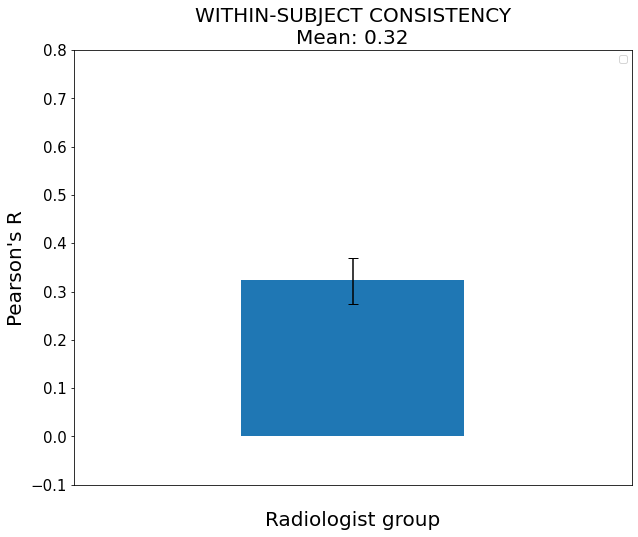

<Figure size 432x288 with 0 Axes>

In [7]:
#PLOT BAR GRAPH WITHIN-SUBJECT CONSISTENCY MEAN

meanAmp = np.mean(TotBoot_means_r)
conf_interval1 = np.percentile(TotBoot_means_r,[2.5])
conf_interval2 = np.percentile(TotBoot_means_r,[97.5])


list1 = [1]

fig1 = plt.figure(figsize=(10,8))

plt.bar(list1, meanAmp, width=0.8, align='center')

plt.axis([0, 2, -0.1, 0.8]) 
#plt.xticks(["Control group"])
#plt.yticks(np.arange(0, 60, 5))

plt.errorbar(list1, meanAmp, yerr=(conf_interval1-meanAmp, meanAmp-conf_interval2), fmt=' ', ecolor='black', capsize=5)

title = "WITHIN-SUBJECT CONSISTENCY\n" + "Mean: " + str(np.round(meanAmp, decimals = 2))  
plt.title(title, fontsize = 20)
plt.xlabel("\nRadiologist group", fontsize = 20)
plt.ylabel("Pearson's R", fontsize = 20)
plt.tick_params(labelsize = 15 ,bottom=False, labelbottom=False)
plt.legend()

plt.show()

FigName = CurrentPath + "/all_graphs/Bootstrap_Within-subjects_BarGraph_3bin.png" #"/Users/" + FolderPathUsers + "/SuperRecognizers/TryConsistencyAnalysis/all_graphs/Bootstrap_Within-subjects_BarGraph_3bin.png"


fig1.tight_layout()
fig1.savefig(FigName, dpi=600)

plt.clf()



**Plotting Data Within-Subject Consistency_singular subjects' graphs** 

<ipython-input-8-2fe7efc3b084>:49: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(list1, meanAmp, yerr=(conf_interval1_calculated_, conf_interval2_calculated_), fmt=' ', ecolor='black', capsize=5)
No handles with labels found to put in legend.


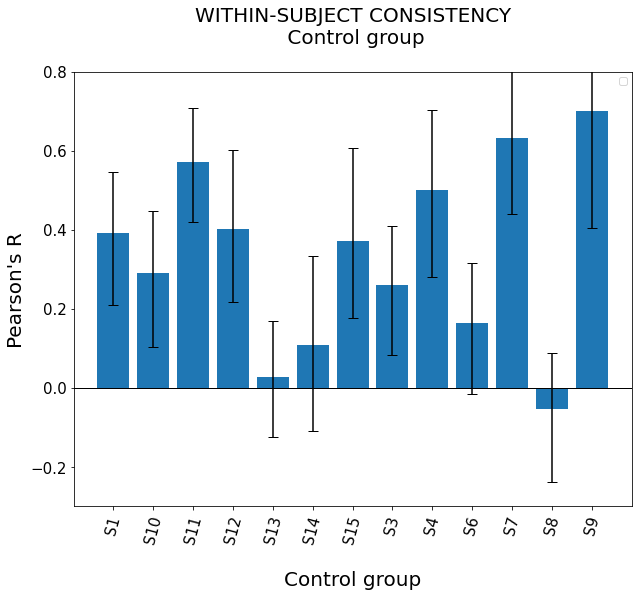

<Figure size 432x288 with 0 Axes>

In [8]:
#PLOT BAR GRAPH WITHIN-SUBJECT CONSISTENCY OF ALL SUBJ


#Prepare data
MEAN_allsubj = []
CI_low_allsubj = []
CI_high_allsubj = []

for p in range(len(Subj)):
    All_iterations_Average_r_Pearson = ALL_CorrSubj[p]

    meanAmp = np.mean(All_iterations_Average_r_Pearson)
    conf_interval1 = np.percentile(All_iterations_Average_r_Pearson,[2.5])
    conf_interval2 = np.percentile(All_iterations_Average_r_Pearson,[97.5])
    #print(meanAmp)
    #print(conf_interval1)
    #print(conf_interval2)
    MEAN_allsubj.append(meanAmp)
    CI_low_allsubj.append(conf_interval1)
    CI_high_allsubj.append(conf_interval2)

    
    
    
#Plot
list1 = Subj
meanAmp = MEAN_allsubj
conf_interval1 = CI_low_allsubj
conf_interval2 = CI_high_allsubj

conf_interval1_calculated_=[]
conf_interval2_calculated_=[]
for x in range(len(conf_interval1)):
    conf_interval1_calculated = conf_interval1[x] - meanAmp[x]
    conf_interval2_calculated = meanAmp[x] - conf_interval2[x]
    conf_interval1_calculated_.append(conf_interval1_calculated)
    conf_interval2_calculated_.append(conf_interval2_calculated)
    


fig1 = plt.figure(figsize=(10,8))

plt.bar(list1, meanAmp, width=0.8, align='center')

plt.axis([-1, len(Subj), -0.3, 0.8]) 
#plt.xticks(["Control group"])
#plt.yticks(np.arange(0, 60, 5))

plt.errorbar(list1, meanAmp, yerr=(conf_interval1_calculated_, conf_interval2_calculated_), fmt=' ', ecolor='black', capsize=5)

title = "WITHIN-SUBJECT CONSISTENCY\n Control group\n"  
plt.title(title, fontsize = 20)
plt.xlabel("\nControl group", fontsize = 20)
plt.ylabel("Pearson's R", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 75)
plt.legend()
plt.axhline(linewidth=1, color='k', linestyle= '-')


plt.show()

FigName = CurrentPath + "/all_graphs/Bootstrap_Within_BarGraph_ALL SUBJECTS.png"


fig1.tight_layout()
fig1.savefig(FigName, dpi=600)

plt.clf()
